In [ ]:
# Install kaggle
! pip install kaggle

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

from keras.models import load_model

from keras.applications import ResNet50


In [2]:
# Mount google drive to get the files from Kaggle via API

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [ ]:
# Upload the json file to Google Drive and then copy to the temporary location.

In [4]:

!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
# Change the file permissions to read/write to the owner only


! chmod 600 ~/.kaggle/kaggle.json

In [6]:
 # Download dataset for emotions

! kaggle datasets download jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 91% 110M/121M [00:00<00:00, 217MB/s] 
100% 121M/121M [00:00<00:00, 202MB/s]


In [7]:
!unzip '/content/face-expression-recognition-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [8]:
picture_size = 48
folder_path = "/content/images/images/"

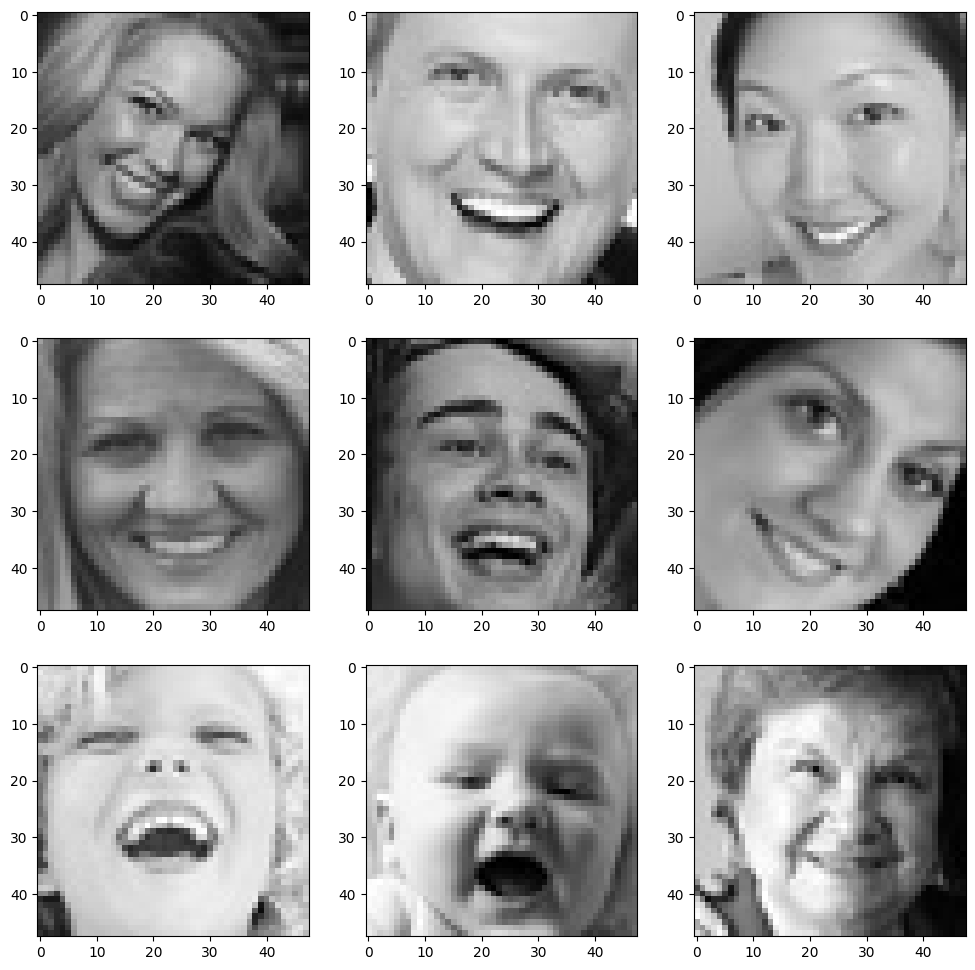

In [9]:
expression = 'happy'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [14]:
# Making Training and Validation Data
batch_size  = 128

rescale_value = 1.0 / 255.0


datagen_train = ImageDataGenerator(rescale=rescale_value)
datagen_val = ImageDataGenerator(rescale=rescale_value)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
# Model Building

In [15]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
# Fitting the Model with Training and Validation Data

In [16]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 10

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [17]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/10


<ipython-input-17-981791b505f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


225/225 [==============================] - ETA: 0s - loss: 1.7930 - accuracy: 0.3147

225/225 [==============================] - 1497s 7s/step - loss: 1.7930 - accuracy: 0.3147 - val_loss: 2.1148 - val_accuracy: 0.1791 - lr: 0.0010
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 1.4389 - accuracy: 0.4430

225/225 [==============================] - 1445s 6s/step - loss: 1.4389 - accuracy: 0.4430 - val_loss: 1.6950 - val_accuracy: 0.3625 - lr: 0.0010
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.5114

225/225 [==============================] - 1444s 6s/step - loss: 1.2762 - accuracy: 0.5114 - val_loss: 1.3771 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 4/10
225/225 [==============================] - ETA: 0s - loss: 1.1963 - accuracy: 0.5401

225/225 [==============================] - 1500s 7s/step - loss: 1.1963 - accuracy: 0.5401 - val_loss: 1.3221 - val_accuracy: 0.4889 - lr: 0.0010
Epoch 5/10
225/225 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.5698

225/225 [==============================] - 1449s 6s/step - loss: 1.1281 - accuracy: 0.5698 - val_loss: 1.2206 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 6/10
225/225 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.5923

225/225 [==============================] - 1548s 7s/step - loss: 1.0796 - accuracy: 0.5923 - val_loss: 1.2052 - val_accuracy: 0.5382 - lr: 0.0010
Epoch 7/10
225/225 [==============================] - ETA: 0s - loss: 1.0272 - accuracy: 0.6110

225/225 [==============================] - 1461s 6s/step - loss: 1.0272 - accuracy: 0.6110 - val_loss: 1.1383 - val_accuracy: 0.5689 - lr: 0.0010
Epoch 8/10
225/225 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.6300

225/225 [==============================] - 1458s 6s/step - loss: 0.9872 - accuracy: 0.6300 - val_loss: 1.1144 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 9/10
225/225 [==============================] - ETA: 0s - loss: 0.9461 - accuracy: 0.6426

225/225 [==============================] - 1439s 6s/step - loss: 0.9461 - accuracy: 0.6426 - val_loss: 1.1509 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 10/10
225/225 [==============================] - ETA: 0s - loss: 0.8978 - accuracy: 0.6638

225/225 [==============================] - 1439s 6s/step - loss: 0.8978 - accuracy: 0.6638 - val_loss: 1.1148 - val_accuracy: 0.5886 - lr: 0.0010


In [ ]:
#Plotting Accuracy & Loss

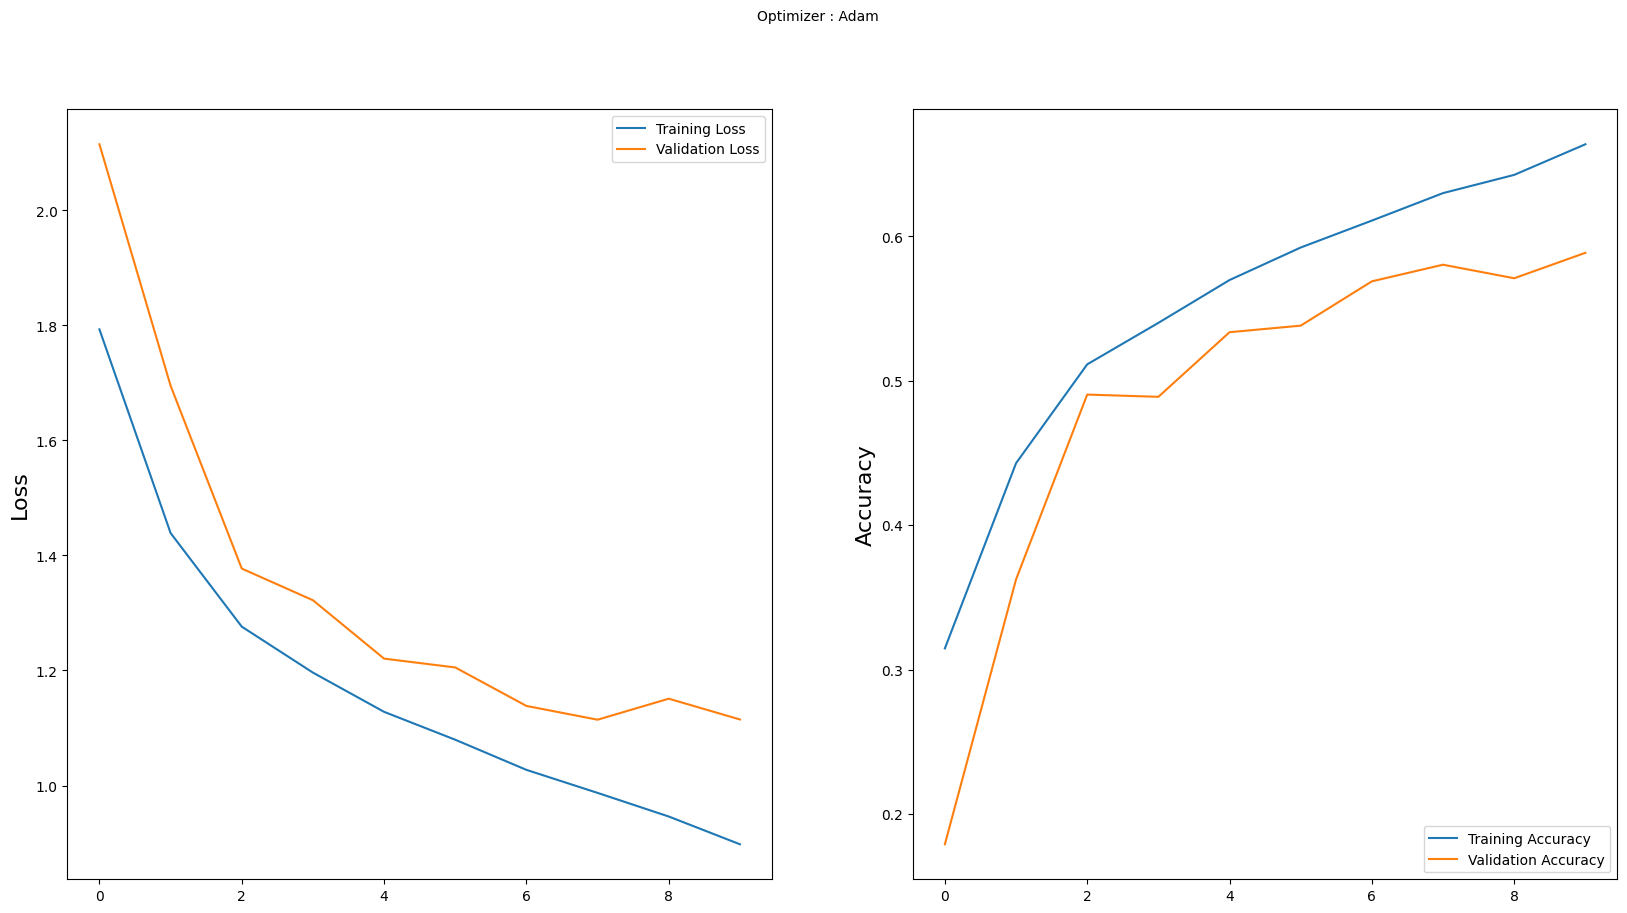

In [18]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Saving the model

In [ ]:
model.save("model24.h5")

In [ ]:
# Load the saved model
loaded_model = load_model("/content/my_model.h5")